In [11]:
import matplotlib.pyplot as plt
# PyTorch
import torch
import torchmetrics

In [37]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import utils
import layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


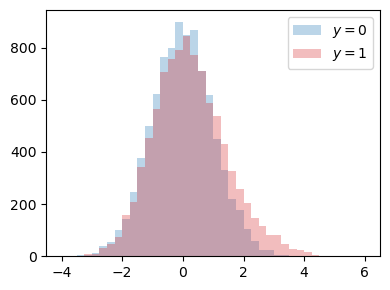

In [13]:
delta = 2.0

X_train, lengths_train, u_train, y_train = utils.generate_data(800, delta=delta, seed=0)
X_val, lengths_val, u_val, y_val = utils.generate_data(100, delta=delta, seed=1)
X_test, lengths_test, u_test, y_test = utils.generate_data(100, delta=delta, seed=2)

X_y0 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 0])
X_y1 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 1])

def get_bins(data, width=0.25):
    min_val, max_val = torch.floor(data.min()), torch.ceil(data.max())
    return torch.arange(min_val, max_val + width, width)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
ax.hist(X_y0[:,0], alpha=0.3, bins=get_bins(X_y0[:,0]), color="#1F77B4", label=r"$y=0$")
ax.hist(X_y1[:,0], alpha=0.3, bins=get_bins(X_y1[:,0]), color="#D62728", label=r"$y=1$")
ax.legend()
fig.tight_layout()
plt.show()

In [14]:
bayes_aurocs = []

deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

with torch.no_grad():
    
    for delta in deltas:
        
        X_train, lengths_train, u_train, y_train = utils.generate_data(800, delta=delta, seed=0)
        X_val, lengths_val, u_val, y_val = utils.generate_data(100, delta=delta, seed=1)
        X_test, lengths_test, u_test, y_test = utils.generate_data(100, delta=delta, seed=2)

        auroc = torchmetrics.AUROC(task="binary", num_labels=1)
        
        bayes_proba = torch.tensor([utils.proba_y1_given_h(X_i[:,0], delta) for X_i in torch.split(X_test, lengths_test)])
        bayes_aurocs.append(auroc(bayes_proba, y_test).item())

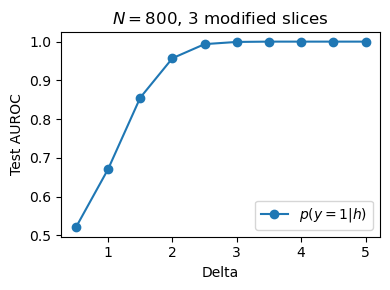

In [32]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
ax.plot(deltas, bayes_aurocs, label=r'$p(y=1|h)$', marker='o',)
ax.set_title(r'$N=800$, 3 modified slices')
ax.set_xlabel('Delta')
ax.set_ylabel('Test AUROC')
ax.legend(loc='lower right')
fig.tight_layout()
plt.show()

In [62]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.embedding = layers.PositionalEmbeddingLayer()
        self.pooling = layers.MaxPooling()
        #self.pooling = layers.MeanPooling()
        #self.pooling = layers.AttentionBasedPooling(in_features=2)

    def forward(self, x, lengths):
        #x = self.embedding(x, lengths)
        x = self.pooling(x, lengths)
        return x

model = Model()

x = torch.rand(10, 1)
lengths = (3, 4, 3)
model(x, lengths)

(tensor([[0.9304],
         [0.3455],
         [0.9323]]),
 tensor([[0],
         [2],
         [1]]))